### Установка пакетов

Начнем с установки необходимых пакетов python. Ничего необычного не понадобится - обычные numpy, cv2, matplotlib

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

Теперь можно импортировать

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

### 2D/3D Преобразования (25 баллов)

Представим, что у вас есть автомобиль, к крыше которого прикреплена RGBD камера. Такая камера снимает как обычная, но четвертым каналом она передает глубину объекта. Глубина объекта - это координаты Z объекта в системе координат камеры (смотри слайд 23 из лекции). Наша задача научиться строить 3D карту по данным с сенсоров этого автомобиля.

Вам дано изображение с этой камеры в какой-то момент времени

In [ ]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

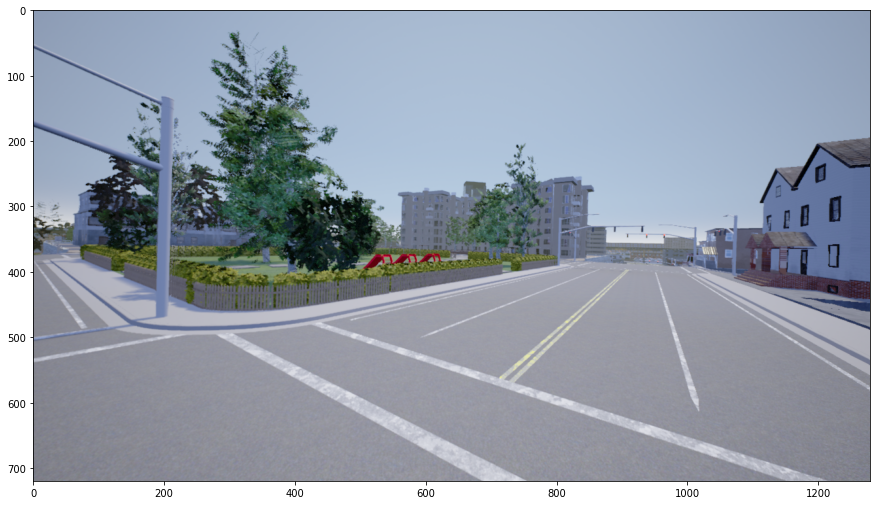

In [ ]:
image1 = load_image("image1.png")
plt.imshow(image1)

А также соответствующая ей карта глубины

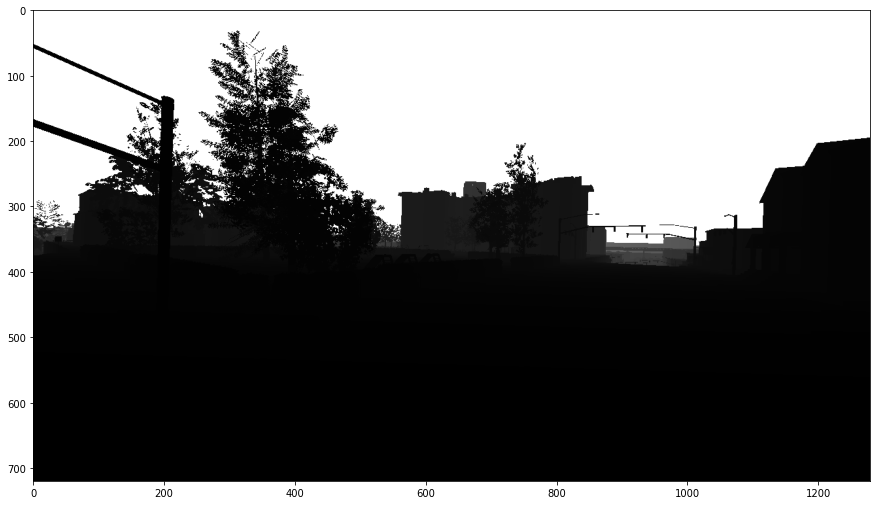

In [ ]:
# Глубины даны нормализованными, от 0 до 1, что соответствует расстоянию от 0 до 1000м,
# поэтому здесь мы умножаем на 1000
depth1 = np.load("depth1.npy") * 1000
plt.imshow(depth1, cmap='gray')

Предположим, что мы заранее откалибровали наши камеры (либо калибровка указана в спецификации камеры). Вот эти данные

In [ ]:
fx = 448.1551643293023
fy = 448.1551643293023
px = 640.0
py = 360.0

Составьте из этих данных матрицу камеры (формулу можно найти в слайдах)

In [ ]:
K = np.array(...) # TODO: заполните матрицу камеры

Также далее нам пригодится обратная матрица для матрицы камеры (можно найти ее численной, но советуем воспользоваться аналитической формулой, она есть в слайдах про обратную проекцию)

In [ ]:
K_inv = np.array(...) # TODO: заполните обратную матрицу камеры

Итак, у нас все готово для построения 3D карты из данных первого изображения.
Для этого нам нужна формула обратной проекции со слайда 36.

Давайте присмотримся повнимательнее к этой формуле:

u, v - это координаты пикселя. Мы хотим построить карту из всех пикселей, поэтому нам нужно пробежаться по всем их значениям. Чтобы векторизовать дальнейшие вычисления, будем записывать все по возможности в матрицах.
points_2d - матрица, в которой 2 строки (u и v), и w * h стоблцов, где w и h - размеры изображения. То есть эта матрица будет выглядеть примерно так

| 0 | 1 | 2 | ... | w-1 | 0 | 1 | ... | w-1 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0 | 0 | 0 | ... | 0 | 1 | 1 | ... | h-1 |

In [ ]:
points_2d = np.array(...) # TODO: заполните марицу с координатами пикселями

Отлично, следующий шаг - перейти к однородным координатам. Здесь это просто - добавьте единицу в качестве третьей координаты для каждого пикселя

In [ ]:
points_2d_h = ... # TODO: переведите points_2d в однородные координаты

Самое время перейти к обратной проекции. Еще раз взгляните на формулу со слайда 36 - что нужно сделать, чтобы из пикселя в однородных координатах получить луч в однородных координатах?

In [ ]:
rays = ... @ points_2d_h # TODO: воостановите формулу для получения матрицы с лучами

Теперь перейдем к последнему этапу формулы со слайда 36 - применение глубины. Используйте ранее загруженную карту глубины

In [ ]:
cloud1 = rays * ... # TODO: преобразуйте лучи и глубины в 3D точки

3D точки готовы! Чтобы 3D была красивая, нам также нужны цвета - вытащите их из изображения аналогично points_2d. Там мы добавляли в столбцы координаты пикселей, а здесь так же постройте матрицу, в которой в столбцах будут соответствующие цвета

In [ ]:
colors1 = ... # TODO: постройте матрицу с цветами пикселей в столбцах

Самый простой способ открыть, покрутить и даже обработать облако точек - использовать [CloudCompare](https://www.danielgm.net/cc/release/). Просто запустите ячейку снизу и закиньте полученный файл в CC.

In [ ]:
def save_point_cloud(cloud: np.ndarray, colors: np.ndarray, file_name: str) -> None:
    file = open(file_name, "w")
    for i in range(cloud1.shape[1]):
        file.write(f'{cloud[0, i]}, {cloud[1, i]}, {cloud[2, i]}, {colors[0, i]}, {colors[1, i]}, {colors[2, i]}\n')

In [ ]:
save_point_cloud(cloud1, colors1, "cloud1.xyz")

Уже почти то, что мы хотели получить. Но карту портят далекие точки - небо находится бесконечно далеко, в карте глубины максимальная глубина была 1000м. Отфильтруйте облако и снова откройте в CC

In [ ]:
cloud1_filtered = ... # Отфильтруйте слишком далекие точки
colors1_filtered = ... # Не забудьте, что цветов тоже стало меньше

In [ ]:
save_point_cloud(cloud1_filtered, colors1_filtered, "cloud1_filtered.xyz")

Итак, мы получили данные с сенсоров и построили небольшую локульную 3D карту. Машина проехала дальше и мы получили новые данные. Загрузим аналогично данные RGBD камеры

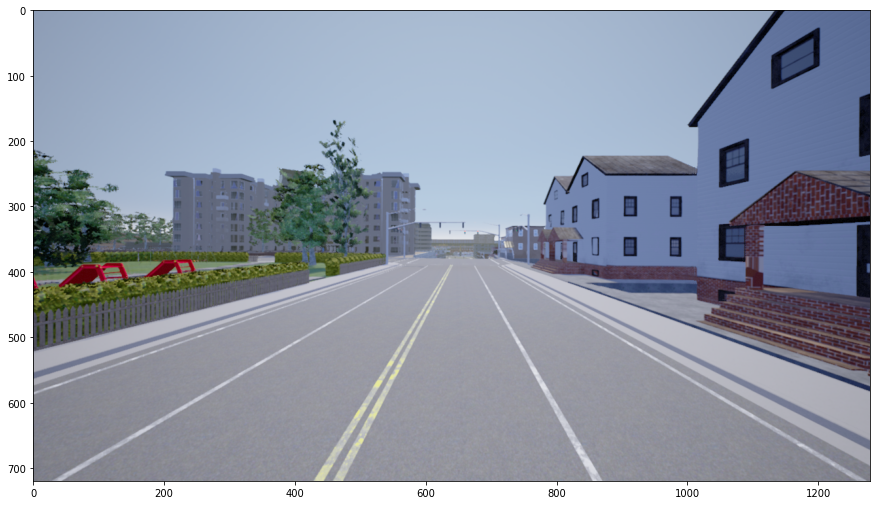

In [ ]:
image2 = load_image("image2.png")
plt.imshow(image2)

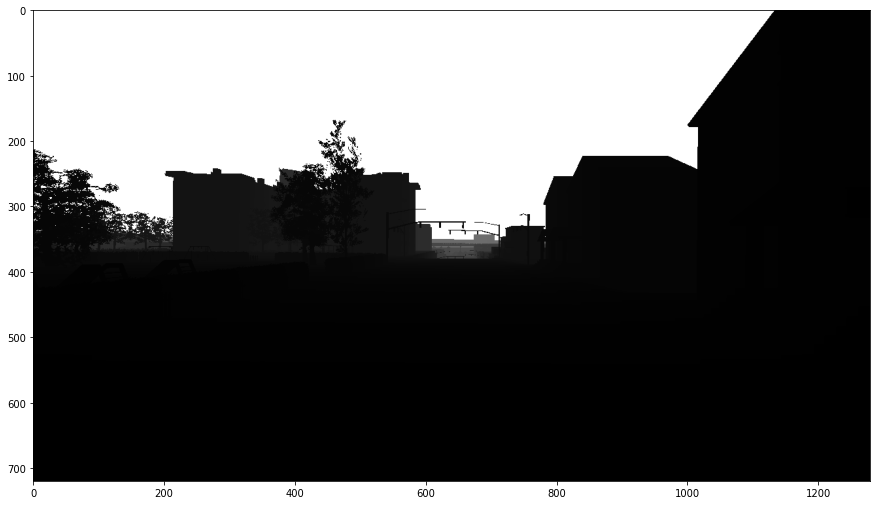

In [ ]:
depth2 = np.load("depth2.npy") * 1000
plt.imshow(depth2, cmap='gray')

Хорошо бы знать, как переместился автомобиль между этими кадрами, но этот вопрос будет разбираться в следующих лекциях. Пока мы считаем, что нам эти данные дает сенсор. Чтобы освежить знания, что такое R и t, обратитесь к разделу "Трансформация системы координат" в слайдах.

In [ ]:
R = np.array([[ 8.50318515e-01,  2.07742095e-02, -5.25858208e-01],
              [-2.47312245e-02,  9.99694013e-01, -4.97406376e-04],
              [ 5.25686969e-01,  1.34280713e-02,  8.50572100e-01]])

t = np.array([[ 6.51715996e-01,  6.20712517e-03, -6.44666629e+00]]).transpose()

В алгоритмах SLAM/SfM одной их самых частых операций является reproject - перепроецирование точки с кадра на кадр. Давайте попробуем сделать это

Возьмем 3 примечательные точки на первом изображении

In [ ]:
landmarks = np.array([
    [560, 856, 1128],
    [280, 276, 313]
])

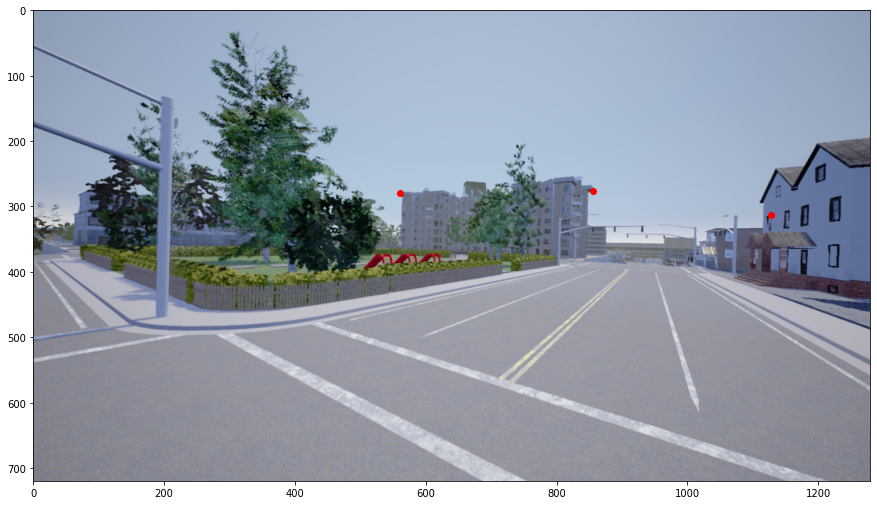

In [ ]:
plt.imshow(image1)
plt.plot(landmarks[0, :], landmarks[1, :], "ro", markersize=6)

С помощью аналогичных операций из предыдущих пунктов, преобразуйте это лэндмарки в 3D точки.

In [ ]:
landmarks_3D_camera1 = ... # получите 3D точки из 2D пикселей

Мы получили 3D в системе координат, связанной с первой камерой. Самое время преобразовать эти точки так, чтобы отобразить их во вторую камеру. Тут вам пригодятся R и t - матрица поворота и смещение

In [ ]:
landmarks_3D_camera2 = ... # преобразуйте landmarks_3D_camera1 во камеру 2.

А теперь проведем операцию, обратную той, с которой мы начали - спроецируем 3D точки в камеру 2. Вам пригодятся формулы со слайда 22

In [ ]:
landmarks_camera2 = ... # спроецируйте landmarks_3D_camera2 на камеру, вам пригодится матрица камеры K

Нарисуем новые точки на втором изображении. Как мы и ожидали, эти точки принадлежат тем же самым объектам. Из следующих лекций вы узнаете, что обычно задача рещается наоборот - мы сначала находим одни и те же точки на двух изображениях (есть много способов это сделать, этому посвящена вторая лекция), а потом по этой информации восстанавливается поза межлу кадрами (R, t) и глубины точек.

In [ ]:
plt.imshow(image2)
plt.plot(landmarks_camera2[0, :], landmarks_camera2[1, :], "ro", markersize=6)

И последнее, что мы сделаем из наших данных - построим наконец совмещенную 3D карту. Все, что нужно для этого, вы уже проделали: возьмите уже построенную карту из первого изображения cloud1 и преобразуйте ее в систему координат второй камеры

In [ ]:
cloud1_filtered_camera2 = ... # преобразуйте cloud1 в систему координат второй камеры с помощью R и t

Теперь просто постройте аналогичное облако точек для второго изображения (второй камеры). Его преобразовывать не нужно, оно уже в системе координат второй камеры. Не забудте его отфильтровать!

In [ ]:
cloud2_filtered_camera2 = ... # постройте cloud2 аналогично тому, как мы строили cloud1

Теперь сохраним оба облака в один файл и любуемся ими в CloudCompare - так должно быть видно консистентное облако.

In [ ]:
save_point_cloud(np.concatenate((cloud1_filtered_camera2, cloud2_filtered_camera2), axis=0),
                 np.concatenate((colors1_filtered, colors2_filtered), axis=0), "cloud2.xyz")

### Гомография (20 баллов максимум)

Используя полученные на лекции новые знания, сделаем простейший выравниватель документов. Перво-наперво, нам нужна фотография документа, который мы будем выравнивать. Можете сфотографировать его сами, можете взять готовый образец.

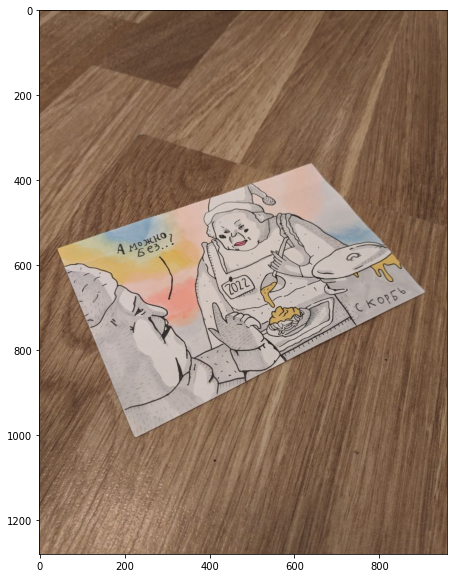

In [ ]:
image = load_image("doc.jpg")
plt.imshow(image)

Для начала нам нужно определить углы документа. Их можно найти автоматически, но предлагаем не отвлекаться на эту задачу, она относится чисто к 2D. Поэтому сделаем это просто руками. Отсчет ведем от левого верхнего угла и по часовой стрелке

In [ ]:
pts_src = np.array([[43, 562], [640, 360], [907, 663],[227, 1005]])

Далее нужно определить, в какие точки мы будем отображать эти углы - сделайте это самостоятельно. Предполагается, что в итоге мы хотим увидеть прямоугольник

In [ ]:
pts_dst = np.array( ... ) # Определите желаемое положение для каждого угла

Теперь мы можем найти гомографию по четырем соответсвиям между точками. Вам предлагается сделать это двумя способами - базово, с использованием OpenCV метода (пример можно найти [здесь](https://learnopencv.com/homography-examples-using-opencv-python-c/)) и продвинуто, с помощью самописной функции DLT (подробнее смотрите слайд 16). Можно легко найти уже написанные функции поиска гомографии с помощью DLT, поэтому снабжайте код пояснениями, чтобы было понятно, что вы разбрались, что происходит в коде.  За каждую функцию начисляется 5 баллов.

In [ ]:
def find_homography_opencv(src_pts: np.ndarray, dst_pts: np.ndarray) -> np.ndarray:
    # Реальзуйте вычсиление гомографии с помощью OpenCV

def find_homography_custom(src_pts: np.ndarray, dst_pts: np.ndarray) -> np.ndarray:
    # Реальзуйте вычсиление гомографии с помощью запописного метода

In [ ]:
H = find_homography_opencv(pts_src, pts_dst)

Зная гомографию, мы можем применить ее к изображению. Опять же, предлагается начать с готового метода из OpenCV (снова предлагается [этот](https://learnopencv.com/homography-examples-using-opencv-python-c/) пример). После этого можно попробовать написать кастомное преобразование изображения с помощью гомографии. За каждую функцию начисляется 5 баллов.

In [ ]:
def warp_perspective_opencv(image: np.ndarray, H: np.ndarray, dsize: np.ndarray) -> np.ndarray:
    # Реализуйте преобразование изображения с помощью OpenCV. Вам понадобятся
    # image - изначальное изображение
    # H - гомография
    # dsize - размер конечного изображения

def warp_perspective_custom(image: np.ndarray, H: np.ndarray, dsize: np.ndarray) -> np.ndarray:
    # Реальзуйте кастомное преобразование изображения. Вам понадобятся
    # image - изначальное изображение
    # H - гомография
    # dsize - размер конечного изображения

In [ ]:
dsize = ... # размеры нового изображения
im_out = warp_perspective_opencv(image, H, dsize)
plt.imshow(im_src)

### Калибровка (5 баллов)

В данном разделе вам предлагается сделать калибровку камеры своего мобильного телефона. Как мы выяснили на занятии, для этого необходима калибровочная доска. Идеальным вариантом будет вывод шахматной доски на экран компьютера, так как он является настолько плоским, насколько это возможно в быту.
Генераторов досок в интернете предостаточно, откройте например [этот](https://markhedleyjones.com/projects/calibration-checkerboard-collection). Далее произведите серию снимков с телефона.

Общие рекомендации:
* Делайте побольше снимков. На практике часто снимают видео, но это на ваше усмотрение. Зависит от желания заморачиваться с распаковкой кадров и прореживанием их.
* Постарайтесь захватить максимум ракурсов: ближе/дальше, выбирайте разные углы наклона, вращайте камеру, постарайтесь захватить всё поле зрение камеры.
* На каждом снимке должна быть видна вся доска. На лекции мы обсуждали почему это важно для обычной доски, здесь просто напоминаю.

Далее проделайте калибровку с помощью стандартных методов OpenCV, пример можно найти [здесь](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) или в миллионе других мест.

Попробуйте убрать дисторсию с помощью функции undistort. Стало ли лучше? Если стало только хуже, обратитесь к рекомендациям по съёмке для калибровки снова.